# **REVERSE IMAGE SEARCH ENGINE - SIMILARITY SEARCH**

# IMPORTS

In [2]:
import numpy as np
import os
import random
from sklearn.neighbors import NearestNeighbors
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from sklearn.decomposition import PCA

# UTILITIES

In [2]:
def extract_classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]

def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(12, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + extract_classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + extract_classname_filename(filenames[i]) + "\nDistance: " + str(float("{0:.2f}".format(distances[i]))))
        plt.axis('off')
        plt.imshow(image)

In [3]:
def apply_knn(features, n=5, metric='cosine'):
  knn = NearestNeighbors(n_neighbors=n, metric=metric).fit(features)
  distances, indices = knn.kneighbors(features)
  return knn, distances, indices

In [4]:
def evaluate_knn_retrieval(features_compressed, class_ids, knn_model, k=5):
    precisions = []
    recalls = []

    for i in range(len(features_compressed)):
        query_label = class_ids[i]
        distances, indices = knn_model.kneighbors([features_compressed[i]], n_neighbors=k+1)

        retrieved_indices = indices[0][1:]
        retrieved_labels = class_ids[retrieved_indices]

        relevant = sum(retrieved_labels == query_label)
        precision = relevant / k

        total_relevant = np.sum(class_ids == query_label) - 1
        recall = relevant / total_relevant if total_relevant > 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)

    return avg_precision, avg_recall

# DATA DOWNLOAD

In [5]:
os.makedirs('/content/caltech101', exist_ok=True)

!curl -L "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1" -o "/content/caltech101/caltech-101.zip"
!unzip "/content/caltech101/caltech-101.zip" -d "/content/caltech101/"
!tar -xzf /content/caltech101/caltech-101/101_ObjectCategories.tar.gz -C /content/caltech101/caltech-101/
!rm -rf /content/101_ObjectCategories/BACKGROUND_Google
!rm -rf /content/caltech101/__MACOSX
!rm -rf /content/caltech101/caltech-101.zip
!rm -rf /content/caltech101/caltech-101/101_ObjectCategories/BACKGROUND_Google

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   476  100   476    0     0   3437      0 --:--:-- --:--:-- --:--:--  3449
100  131M  100  131M    0     0  53.7M      0  0:00:02  0:00:02 --:--:-- 63.2M
Archive:  /content/caltech101/caltech-101.zip
   creating: /content/caltech101/caltech-101/
  inflating: /content/caltech101/__MACOSX/._caltech-101  
  inflating: /content/caltech101/caltech-101/101_ObjectCategories.tar.gz  
  inflating: /content/caltech101/__MACOSX/caltech-101/._101_ObjectCategories.tar.gz  
  inflating: /content/caltech101/caltech-101/show_annotation.m  
  inflating: /content/caltech101/__MACOSX/caltech-101/._show_annotation.m  
  inflating: /content/caltech101/caltech-101/Annotations.tar  
  inflating: /content/caltech101/__MACOSX/caltech-101/._Annotations.tar  


# LOADING SAVED FEATURES, FILENAMES & CLASS IDS

In [5]:
features = np.load("../features_data/features.npy")
filenames = np.load("../features_data/filenames.npy", allow_pickle=True)
class_ids = np.load("../features_data/class_ids.npy")

print("Features:", features.shape)
print("Filenames:", len(filenames))
print("Class IDs:", len(class_ids))

num_images = 8677

Features: (8677, 2048)
Filenames: 8677
Class IDs: 8677


# SIMILARITY SEARCH USING EUCLIDEAN DISTANCE

In [14]:
n = 11
knn_euc, distances, indices = apply_knn(features, n=n, metric='euclidean')

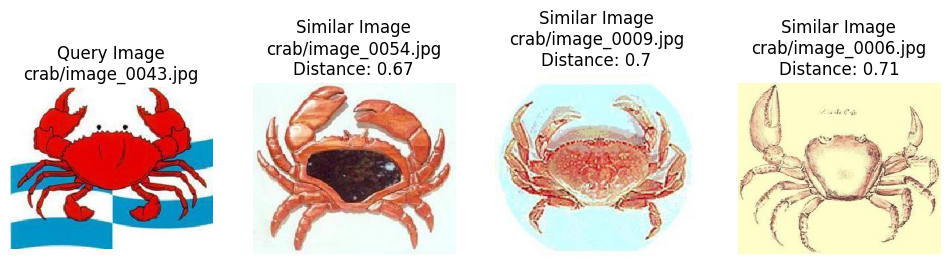

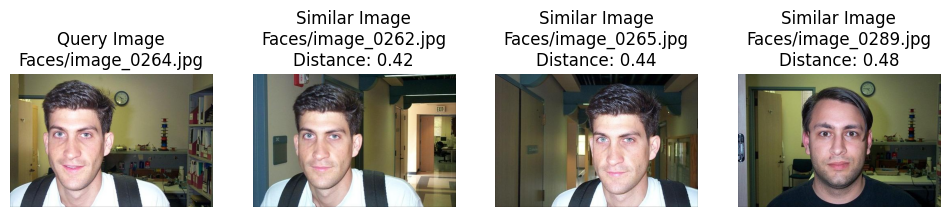

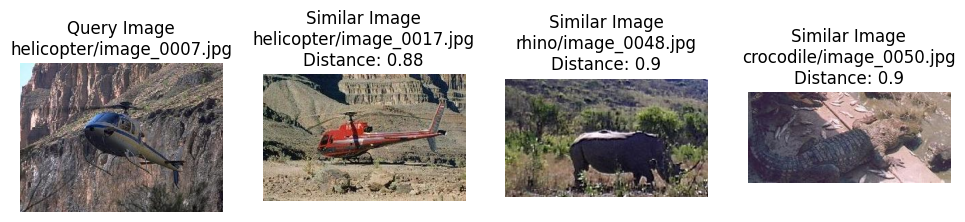

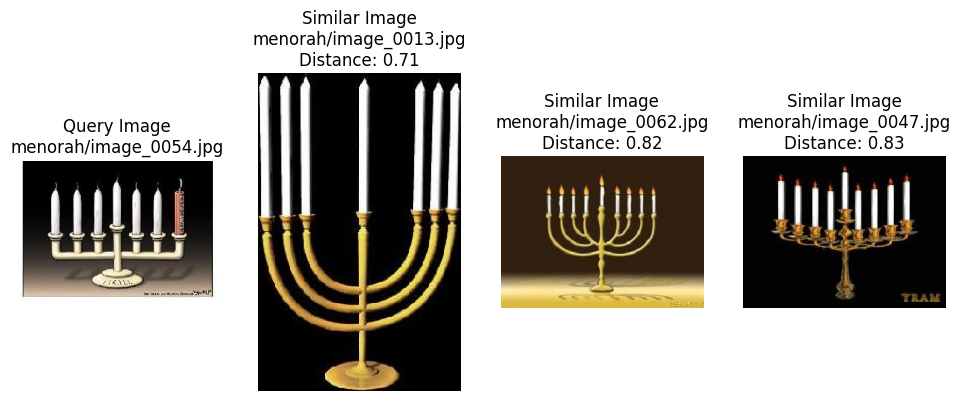

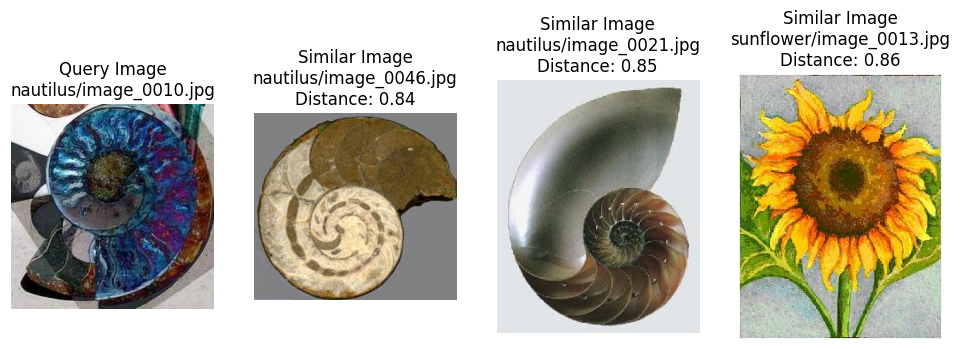

In [15]:
for _ in range(5):
    random_image_index = random.randint(0, num_images)
    distances, indices = knn_euc.kneighbors(
        [features[random_image_index]]
    )
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

# SIMILARITY SEARCH USING COSINE SIMILARITY

In [17]:
n = 11
knn_cos, distances, indices = apply_knn(features, n=n, metric='cosine')

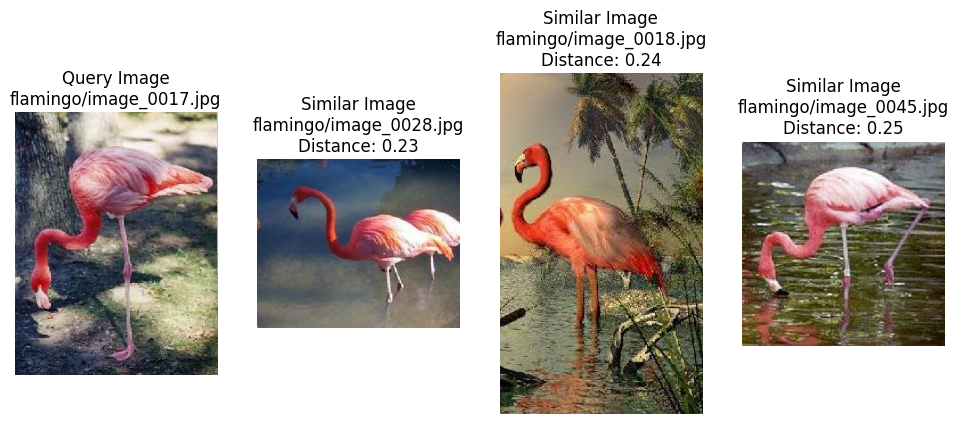

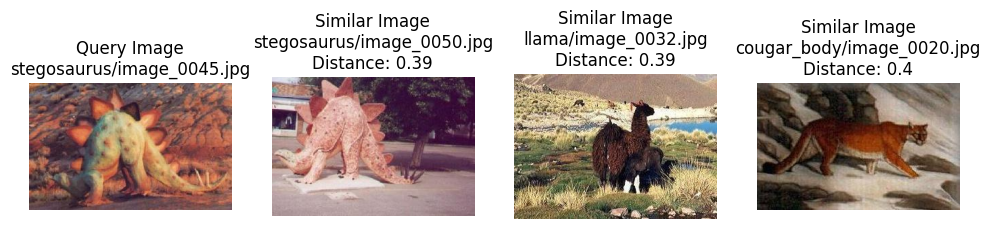

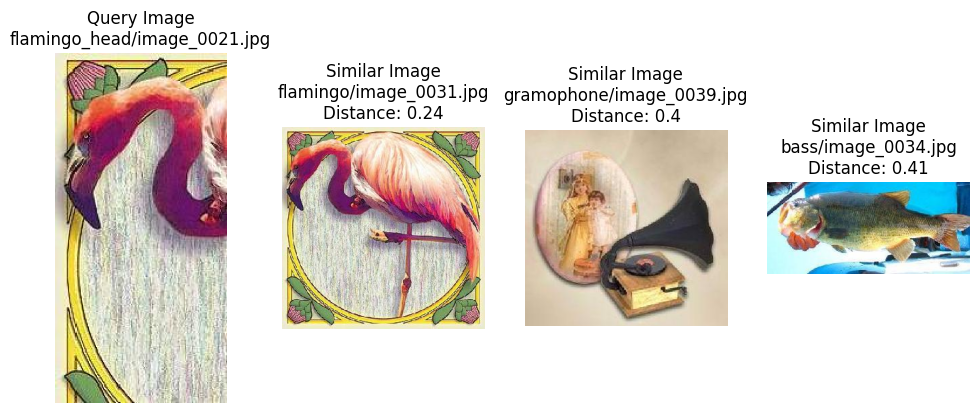

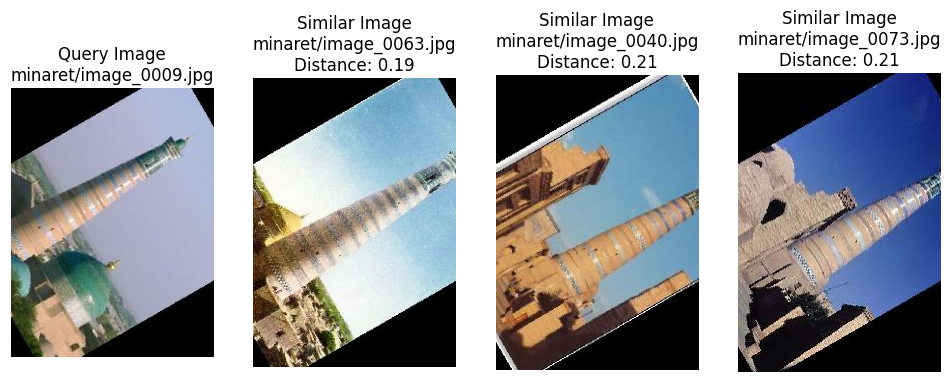

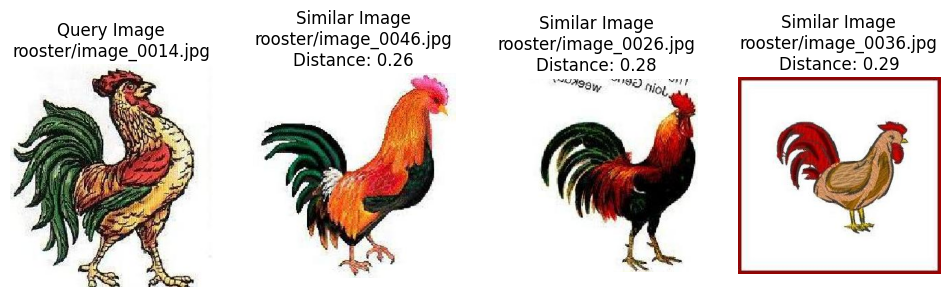

In [18]:
for _ in range(5):
    random_image_index = random.randint(0, num_images)
    distances, indices = knn_cos.kneighbors(
        [features[random_image_index]]
    )
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

# DIMENSIONALITY REDUCTION

Reason: to speed up search on large datasets and improve quality by removing noise and keeping only important features.

In [11]:
num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(features)
feature_list_compressed = pca.transform(features)

# SIMILARITY SEARCH AFTER DIMENSIONALITY REDUCTION USING EUCLIDEAN DISTANCE

In [19]:
knn_euc_pca, distances, indices = apply_knn(feature_list_compressed, n=n, metric='euclidean')

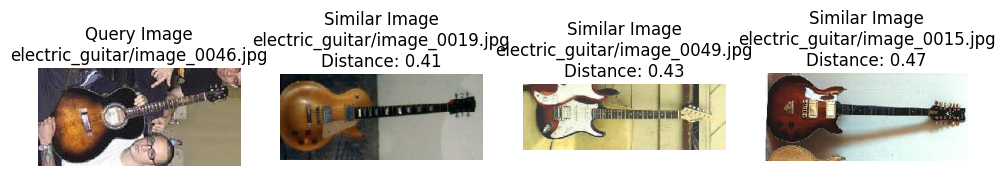

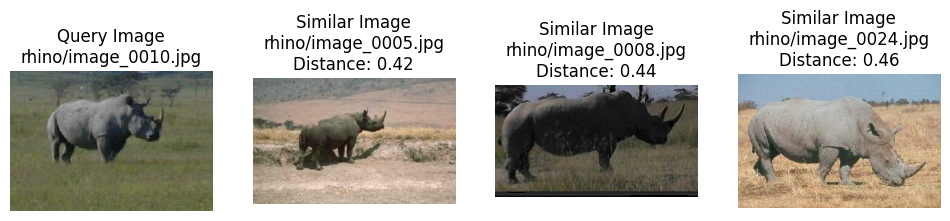

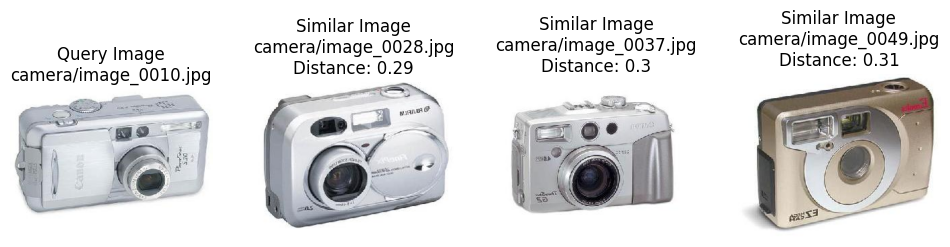

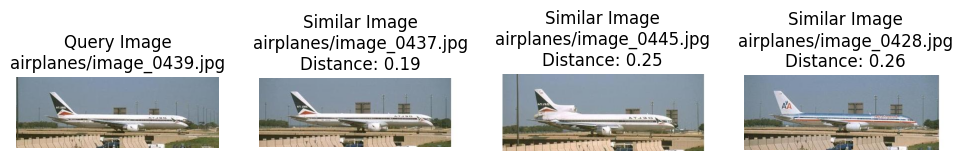

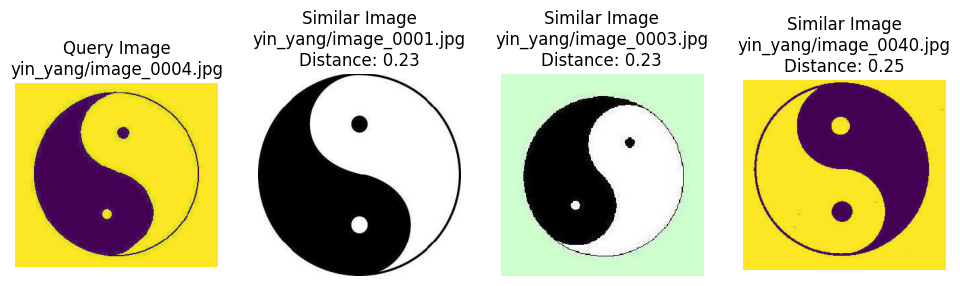

In [20]:
for i in range(5):
    random_image_index = random.randint(0, num_images)
    distances, indices = knn_euc_pca.kneighbors(
        [feature_list_compressed[random_image_index]])
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

# SIMILARITY SEARCH AFTER DIMENSIONALITY REDUCTION USING COSINE SIMILARITY

In [22]:
knn_cos_pca, distances, indices = apply_knn(feature_list_compressed, n=n, metric='cosine')

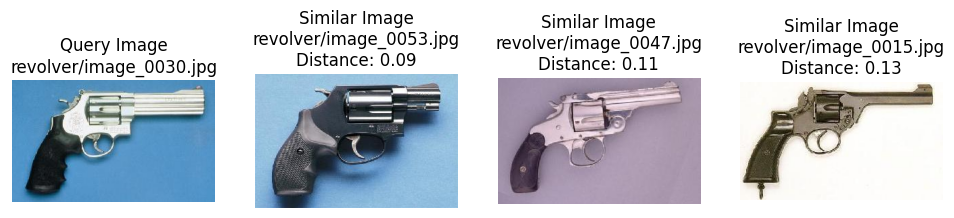

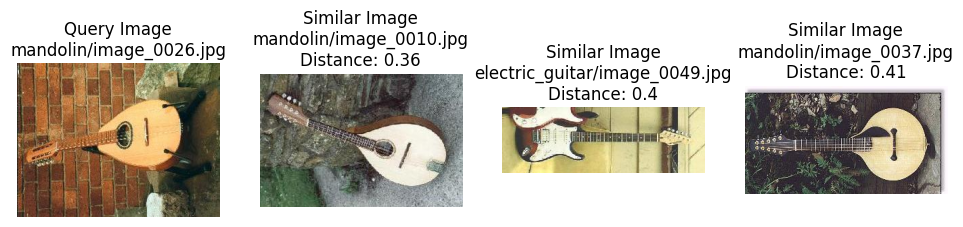

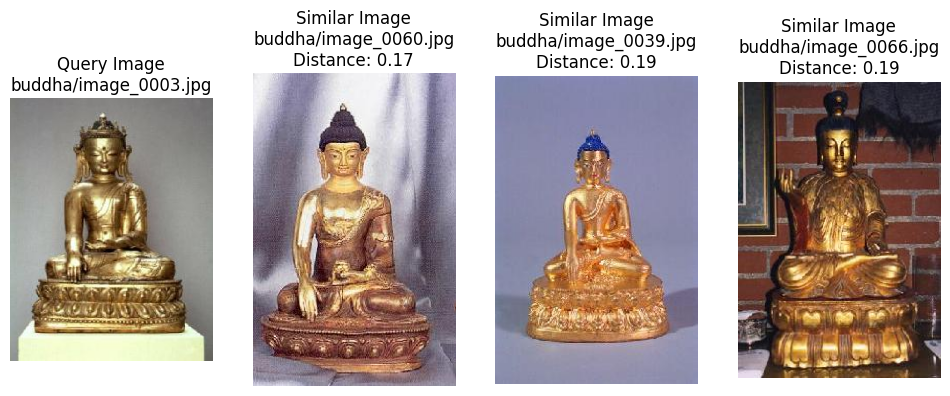

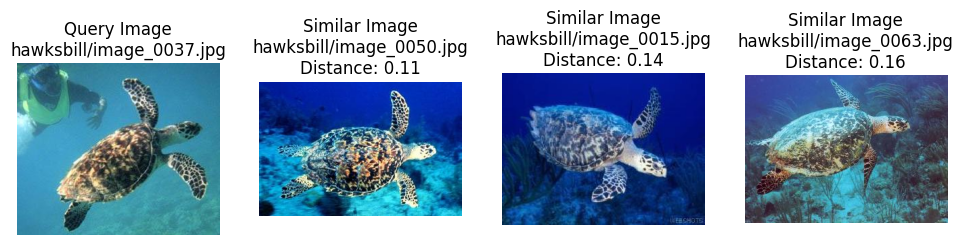

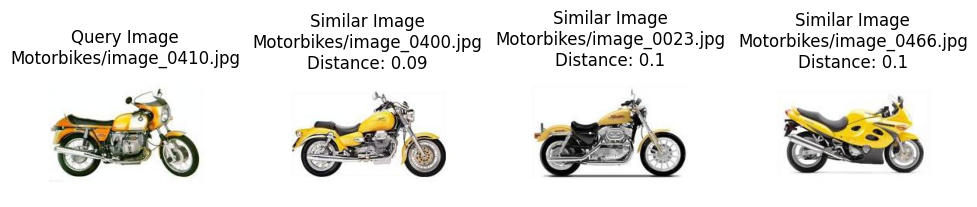

In [23]:
for i in range(5):
    random_image_index = random.randint(0, num_images)
    distances, indices = knn_cos_pca.kneighbors(
        [feature_list_compressed[random_image_index]])
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

# PERFORMANCE EVALUATION

In [24]:
k = 100
avg_precision, avg_recall = evaluate_knn_retrieval(features, class_ids, knn_euc, k=k)
print("Similairty Search with Euclidean Distance")
print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")

Similairty Search with Euclidean Distance
Average Precision@100: 0.6020
Average Recall@100: 0.4942


In [25]:
avg_precision, avg_recall = evaluate_knn_retrieval(features, class_ids, knn_cos, k=k)
print("Similairty Search with Cosine Similarity")
print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")

Similairty Search with Cosine Similarity
Average Precision@100: 0.6020
Average Recall@100: 0.4942


In [27]:
avg_precision, avg_recall = evaluate_knn_retrieval(feature_list_compressed, class_ids, knn_euc_pca, k=k)
print("Similairty Search with Euclidean Distance after Dimensionality Reduction")
print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")

Similairty Search with Euclidean Distance after Dimensionality Reduction
Average Precision@100: 0.6175
Average Recall@100: 0.5104


In [28]:
avg_precision, avg_recall = evaluate_knn_retrieval(feature_list_compressed, class_ids, knn_cos_pca, k=k)
print("Similairty Search with Cosine Similarity after Dimensionality Reduction")
print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")

Similairty Search with Cosine Similarity after Dimensionality Reduction
Average Precision@100: 0.6175
Average Recall@100: 0.5104
